# 영화 리뷰 감성 분석

In [2]:
import gzip
import shutil

# 압축 해제할 .gz 파일 경로와 출력 파일 경로를 설정
input_gz_file = './data/aclImdb_v1.tar.gz'
output_file = './data/aclImdb_v1.tar'

# gzip 파일 압축 해제
with gzip.open(input_gz_file, 'rb') as gz_file:
    with open(output_file, 'wb') as out_file:
        shutil.copyfileobj(gz_file, out_file)

print(f"압축 해제 완료: {output_file}")

import tarfile

# 압축 해제할 tar 파일 경로와 출력 디렉터리를 설정
input_tar_file = './data/aclImdb_v1.tar'
output_directory = './data/'

# tar 파일 압축 해제
with tarfile.open(input_tar_file, 'r') as tar:
    tar.extractall(path=output_directory)
    print(f"압축 해제 완료: {output_directory}")

압축 해제 완료: ./data/aclImdb_v1.tar


C:\Users\PC\AppData\Local\Temp\ipykernel_35164\1909218022.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=output_directory)


압축 해제 완료: ./data/


## 데이터 로드 및 EDA

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
def load_data(data_dir):
    texts = []
    labels = []
    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(0 if label_type == 'neg' else 1)
    return pd.DataFrame({'text':texts, 'label':labels})

train_df = load_data('./data/aclImdb/train')
test_df = load_data('./data/aclImdb/test')

In [4]:
# 데이터 분포 확인
print(train_df['label'].value_counts())

label
0    12500
1    12500
Name: count, dtype: int64


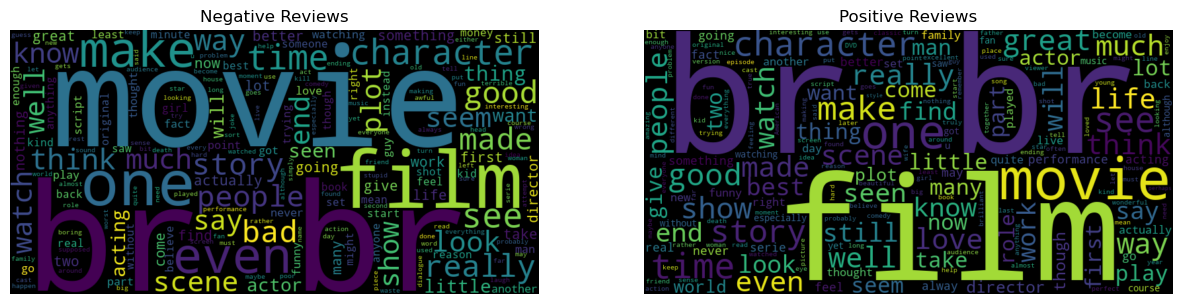

In [5]:
# 워드클라우드 생성
neg_text = ' '.join(train_df[train_df['label'] == 0]['text'])
pos_text = ' '.join(train_df[train_df['label'] == 1]['text'])

neg_wordcloud = WordCloud(width=800, height=400).generate(neg_text)
pos_wordcloud = WordCloud(width=800, height=400).generate(pos_text)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')
plt.subplot(1, 2, 2)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')
plt.show()

## 데이터 전처리

In [6]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

## 전통적인 머신러닝 모델 학습

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [9]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_df['label']
y_test = test_df['label']

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

y_pred_nb = model_nb.predict(X_test)
print('나이브 베이즈 분류기 성능:')
print(classification_report(y_test, y_pred_nb))

나이브 베이즈 분류기 성능:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     12500
           1       0.85      0.81      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## 딥러닝 모델 학습 (간단한 LSTM)

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [12]:
max_words = 5000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

X_train_pad = pad_sequences(X_train_seq, max_len)
X_test_pad = pad_sequences(X_test_seq, max_len)

model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 128, input_length=max_len))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)

c:\Users\PC\miniconda3\envs\portfolio\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 144ms/step - accuracy: 0.7467 - loss: 0.4942 - val_accuracy: 0.7398 - val_loss: 0.6031
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.9143 - loss: 0.2302 - val_accuracy: 0.7258 - val_loss: 0.6371
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.9309 - loss: 0.1868 - val_accuracy: 0.7370 - val_loss: 0.7123
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.9494 - loss: 0.1479 - val_accuracy: 0.7742 - val_loss: 0.7571
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.9551 - loss: 0.1304 - val_accuracy: 0.7452 - val_loss: 0.8101


In [13]:
# 평가
y_pred_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype('int32')
print('LSTM 모델 성능:')
print(classification_report(y_test, y_pred_lstm))

782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step
LSTM 모델 성능:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     12500
           1       0.87      0.79      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## LLM 활용 (BERT Fine-tuning)

In [17]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
def encode_data(texts, labels, max_length=512):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks), np.array(labels)

In [ ]:
X_train_ids, X_train_masks, y_train = encode_data(train_df['text'], train_df['label'])
X_test_ids, X_test_masks, y_test = encode_data(test_df['text'], test_df['label'])

model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # 이진 분류용 num_labels=1 설정

optimizer = tf.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # from_logits=True 설정 필요
model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model_bert.fit(
    [X_train_ids, X_train_masks],
    y_train.reshape(-1, 1),  # 레이블 형식을 (None, 1)로 맞춤
    epochs=2,
    batch_size=8,
    validation_split=0.1
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


 209/2813 [=>............................] - ETA: 10:28:39 - loss: 0.4106 - accuracy: 0.7937

In [ ]:
# 평가
y_pred_bert = (model_bert.predict([X_test_ids, X_test_masks]).logit > 0).astype('int32')
print('BERT 모델 성능:')
print(classification_report(y_test, y_pred_bert))